# Fractions of ploidy levels in hepatocytes

## Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import mixture

%load_ext rpy2.ipython

In [2]:
%R require(ggplot2)

R[write to console]: Loading required package: ggplot2



array([1], dtype=int32)

In [3]:
def calc_mode(data, eval_N = 10000):
    eval_sizes = np.linspace(np.min(data), np.max(data), eval_N)
    return eval_sizes[np.argmax(sp.stats.gaussian_kde(data)(eval_sizes))]

## Reading the data

In [4]:
nuclei = pd.read_excel('../../../data/Nuclei_diameters+calculated_volumes.xlsx', usecols=np.arange(7))
nuclei = pd.melt(nuclei, var_name='sample', value_name='diameter').dropna()

nuclei['volume'] = 4/3*np.pi*(nuclei['diameter']/2)

In [5]:
nuclei.head()

,sample,diameter,volume
0,HL#3,7.7,16.126842
1,HL#3,6.4,13.404129
2,HL#3,11.0,23.038346
3,HL#3,7.6,15.917403
4,HL#3,8.1,16.964600


## EDA

NameError: name 'mode' is not defined

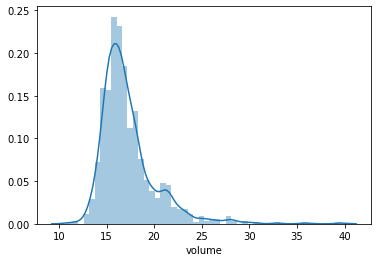

In [6]:
sns.distplot(nuclei['volume'])
plt.axvline(mode(nuclei['volume']))
plt.show()

In [ ]:
for name, data in nuclei.groupby('sample'):
    sns.kdeplot(data['volume'], label=name)
plt.show()

## Estimating the modes for each sample

In [ ]:
modes = nuclei.groupby('sample').apply(lambda data: calc_mode(data['volume']))
modes.name = 'mode'
modes

In [ ]:
groupby = nuclei.groupby('sample')
fig, axs = plt.subplots(len(groupby), sharex=True, figsize=(6,8))
for (name, data), ax in zip(nuclei.groupby('sample'), axs):
    sns.distplot(data['volume'], label=name, bins=30, ax=ax, axlabel='')
    ax.axvline(mode(data['volume']))
    ax.legend()

ax.set_xlabel('volume')
plt.show()

In [ ]:
nuclei = nuclei.join(modes, on='sample')

In [ ]:
nuclei['normalised_volume'] = nuclei['volume'] / nuclei['mode']

In [ ]:
for name, data in nuclei.groupby('sample'):
    sns.kdeplot(data['normalised_volume'], label=name)
plt.show()

In [ ]:
%%R -i nuclei -w 1200
ggplot(nuclei, aes(x=normalised_volume, color=sample)) + geom_freqpoly(binwidth=0.05)

In [ ]:
%%R -i nuclei -w 1200
ggplot(nuclei, aes(x=normalised_volume)) + geom_histogram(binwidth=0.05) + geom_density() + facet_wrap( ~ sample, ncol=7)

## Estimating ploidy fractions

### Threshold-based approach

In [ ]:
sns.distplot(nuclei['normalised_volume'])
threshold_2n = 1.2
threshold_4n = 1.5
plt.axvline(threshold_2n)
plt.axvline(threshold_4n)

In [ ]:
nuclei['ploidy_threshold'] = [2 if nv < threshold_2n else (4 if nv < threshold_4n else 6) for nv in nuclei['normalised_volume']]

In [ ]:
nuclei.groupby(['sample', 'ploidy_threshold']).size() / nuclei.groupby(['sample']).size()

### Gaussian mixture model

In [ ]:
n_components = 3
means_init= np.linspace(1, 1.7, n_components).reshape(-1, 1)
weights_init=[0.8] + (n_components - 1) * [0.2/(n_components - 1)]

clf = mixture.GaussianMixture(n_components=n_components, max_iter=10000, 
                              weights_init=weights_init,
                              means_init=means_init, random_state=0)

clf.fit(nuclei['normalised_volume'].values.reshape(-1, 1))

sns.distplot(nuclei['normalised_volume'])
x = np.linspace(0, 2.5)
plt.plot(x, np.exp(clf.score_samples(x.reshape(-1, 1))))

for loc, scale, weight in zip(clf.means_, np.sqrt(clf.covariances_), clf.weights_):
    plt.plot(x, weight * sp.stats.norm.pdf(x, loc=loc, scale=scale)[0])

for pos in clf.means_:
    plt.axvline(pos)
    
# plt.yscale('log')
# plt.ylim(0.1, 10)
plt.show()

In [ ]:
clf.weights_

In [ ]:
clf.means_

In [ ]:
nuclei['ploidy'] = 2*(clf.predict(nuclei['normalised_volume'].values.reshape(-1, 1))+1)

nuclei.groupby(['sample', 'ploidy']).size() / nuclei.groupby(['sample']).size()

In [ ]:
groupby = nuclei.groupby('sample')
fig, axs = plt.subplots(len(groupby), sharex=True, figsize=(6,8))
for (name, data), ax in zip(nuclei.groupby('sample'), axs):
    sns.distplot(data['normalised_volume'], label=name, bins=30, ax=ax, axlabel='')
    ax.plot(x, np.exp(clf.score_samples(x.reshape(-1, 1))))
    ax.axvline(1)
    ax.legend()

ax.set_xlabel('normalised_volume')
plt.show()

In [ ]:
for name, data in nuclei.groupby('ploidy_threshold'):
    sns.distplot(data['normalised_volume'], bins=np.linspace(0.75, 2.5, 30), norm_hist=False, kde=False, label=name)

plt.legend(title='Ploidy')
plt.ylabel('cell number')
plt.show()

#### Uncertainties

In [ ]:
nuclei.head()

In [ ]:
def sample_nuclei(nuclei, random_state=None):
    return nuclei.groupby('sample', group_keys=False).apply(lambda x: x.sample(frac=1, replace=True, random_state=random_state))

In [ ]:
def ploidy_levels(nuclei):
    n_components = 3
    means_init= np.linspace(1, 1.7, n_components).reshape(-1, 1)
    weights_init=[0.8] + (n_components - 1) * [0.2/(n_components - 1)]

    clf = mixture.GaussianMixture(n_components=n_components, max_iter=10000, 
                                  weights_init=weights_init,
                                  means_init=means_init, random_state=0)

    labels = clf.fit_predict(nuclei['normalised_volume'].values.reshape(-1, 1))
    ploidy = 2*(labels+1)

    return ploidy

In [ ]:
def sample_ploidy_fractions(nuclei, random_state=None):
    if random_state is None:
        random_state = None
    nuclei = sample(nuclei, random_state=random_state)
    ploidy = ploidy_levels(nuclei)
    nuclei['ploidy'] = ploidy
    
    ploidy_fractions = pd.DataFrame(nuclei.groupby(['sample', 'ploidy']).size() / nuclei.groupby(['sample']).size(), columns=['fraction'])
#     if random_state is None:
#         ploidy_fractions['random_state'] = np.nan
#     else:
    ploidy_fractions['random_state'] = random_state
    return ploidy_fractions.reset_index()

In [ ]:
N_bootstrap = 1000
bootstrap_result = pd.concat([sample_ploidy_fractions(nuclei, random_state) for random_state in np.arange(100)])

In [ ]:
ploidy = bootstrap_result.groupby(['sample', 'ploidy'])['fraction'].agg(['mean', 'std']).reset_index()
ploidy['ploidy'] = pd.Categorical(ploidy['ploidy'])
ploidy